In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
data = pd.read_csv('data/twitter_sentiment/training.1600000.processed.noemoticon.csv', encoding = 'latin', header = None)
data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']

In [4]:
data.head(5)

sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

           user_id  \
0  _TheSpecialOne_   
1    scotthamilton   
2         mattycus   
3          ElleCTF   
4           Karoli   

                                                                                                                  text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
1      is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!  
2                            @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds  
3                                                                      my whole body feels itchy and like its on fire   
4      @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.

In [5]:
data['sentiment'] = data['sentiment'].map({0 : "negative", 4 : "positive"})

In [6]:
data['sentiment'].value_counts()

sentiment
negative    800000
positive    800000
Name: count, dtype: int64

## Preprocessing Text

In [7]:
import re
import html
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('popular')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Skyglow\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Skyglow\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Skyglow\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Skyglow\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [8]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

def decontracted(phrase):
    phrase = re.sub(r"\bcan\'t\b", "cannot", phrase)
    phrase = re.sub(r"\bwon\'t\b", "will not", phrase)
    phrase = re.sub(r"\bdon\'t\b", "do not", phrase)
    phrase = re.sub(r"\bdoesn\'t\b", "does not", phrase)
    phrase = re.sub(r"\bwasn\'t\b", "was not", phrase)
    phrase = re.sub(r"\bisn\'t\b", "is not", phrase)
    phrase = re.sub(r"\baren\'t\b", "are not", phrase)
    phrase = re.sub(r"\bweren\'t\b", "were not", phrase)
    phrase = re.sub(r"\bhasn\'t\b", "has not", phrase)
    phrase = re.sub(r"\bhaven\'t\b", "have not", phrase)
    phrase = re.sub(r"\bshouldn\'t\b", "should not", phrase)
    phrase = re.sub(r"\bwouldn\'t\b", "would not", phrase)
    phrase = re.sub(r"\bcouldn\'t\b", "could not", phrase)
    phrase = re.sub(r"\b\'t", " not", phrase)
    phrase = re.sub(r"\b\'re", " are", phrase)
    phrase = re.sub(r"\b\'s", " is", phrase)
    phrase = re.sub(r"\b\'d", " would", phrase)
    phrase = re.sub(r"\b\'ll", " will", phrase)
    phrase = re.sub(r"\b\'ve", " have", phrase)
    phrase = re.sub(r"\b\'m", " am", phrase)
    return phrase.strip()

In [9]:
def clean_tweet(tweet):
    urlPattern = 'https?://\S+|www\.\S+'
    usernamePattern = '@([A-Za-z0-9_]+)' #From https://help.x.com/en/managing-your-account/x-username-rules 
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    alphaNumeric = r'[^A-Za-z0-9\s]'
    spacePattern = r'\s+'

    lemmatizer = WordNetLemmatizer()
    auxiliary_verbs = {"am", "is", "are", "was", "were"}

    # Remove URLs
    tweet = re.sub(urlPattern, '', tweet)
    # Remove usernames
    tweet = re.sub(usernamePattern, '', tweet)
    # Clean HTML texts like &lt; (<) or &amp; (&)
    tweet = html.unescape(tweet)
    # Convert accented characters to ASCII
    tweet = unidecode(tweet)
    # Decontract words I'm => I am, Don't => Do not
    tweet = decontracted(tweet)
    # Remove special characters
    tweet = re.sub(alphaNumeric, ' ', tweet)
    # Removes extra spaces
    tweet = re.sub(spacePattern, ' ', tweet).strip()
    # Removes 3 or more consecutive letters by two letters. (e.g. Hiiiii!!!!)
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Tokenize and lemmatize
    tokens = word_tokenize(tweet)
    # print(tokens)
    pos_tags = pos_tag(tokens)
    
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    tokens = [
        word if word in auxiliary_verbs else lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tags
    ]

    # print(tokens)
    tweet = ' '.join(tokens)
    
    return tweet

In [10]:
data.columns

Index(['sentiment', 'id', 'date', 'query', 'user_id', 'text'], dtype='object')

In [11]:
data[data['text'].str.contains("amp", case=False, na=False)] #ó Á é ö heyyyy

sentiment          id                          date     query  \
35       negative  1467816749  Mon Apr 06 22:21:20 PDT 2009  NO_QUERY   
145      negative  1467843647  Mon Apr 06 22:28:24 PDT 2009  NO_QUERY   
242      negative  1467873256  Mon Apr 06 22:36:06 PDT 2009  NO_QUERY   
256      negative  1467876652  Mon Apr 06 22:37:03 PDT 2009  NO_QUERY   
262      negative  1467878057  Mon Apr 06 22:37:26 PDT 2009  NO_QUERY   
...           ...         ...                           ...       ...   
1599870  positive  2193553366  Tue Jun 16 08:36:51 PDT 2009  NO_QUERY   
1599921  positive  2193575912  Tue Jun 16 08:38:42 PDT 2009  NO_QUERY   
1599954  positive  2193577602  Tue Jun 16 08:38:51 PDT 2009  NO_QUERY   
1599965  positive  2193577918  Tue Jun 16 08:38:53 PDT 2009  NO_QUERY   
1599970  positive  2193578196  Tue Jun 16 08:38:54 PDT 2009  NO_QUERY   

                 user_id  \
35        scarletletterm   
145         treehugger25   
242             nicci718   
256        SupernovaGirl   
262      debbieseraphina   
...                  ...   
1599870           AnnieR   
1599921     followtweety   
1599954       charitojoy   
1599965     milliontwits   
1599970    adbillingsley   

                                                                                                                                                   text  
35                      ok I'm sick and spent an hour sitting in the shower cause I was too sick to stand and held back the puke like a champ. BED now   
145               @twista202 I still haven't read the 9th&amp;10th Princess diaries  Saving Francesca made me cry at the end. Hmm those are easy books.  
242                                                                        @kristencampisi is this it 4 u? Its ' officially over ' 4 me this go round!   
256           @burgaw Ooooooh! *sealclap* See, I download shitloads of zip folders off 4chan. I have no internet moneys.  FUCK YEAH ALICIA &amp; MIKEY.  
262                                                                                                          help me forget 8th april &amp; 13th july!   
...                                                                                                                                                 ...  
1599870                              @ddribin Saw that &amp; approved, re: bike. After years of being exceedingly bike UNfriendly, we are a' changin'!   
1599921  I just switched back to Opera (using the moi skin). It's really fast &amp; stable to work with - I'm loving it  http://www.opera.com/download/  
1599954                         God works mysteriously!i learn that if u think of the world wonderfully you will receive more &amp; get what u ask for   
1599965   @stum450n Hi. Thanks for the follow. Nice website... check your carriage returns though, the bottom of 'Website &amp; brand identity' is out   
1599970                                                               Thanks @eastwestchic &amp; @wangyip Thanks! That was just what I was looking for   

[54461 rows x 6 columns]

In [12]:
data[data['text'].str.contains(".com", case=False, na=False)].sample(5)

sentiment          id                          date     query  \
1441796  positive  2061877877  Sat Jun 06 21:49:11 PDT 2009  NO_QUERY   
534605   negative  2197597296  Tue Jun 16 14:48:57 PDT 2009  NO_QUERY   
606068   negative  2222466506  Thu Jun 18 07:01:18 PDT 2009  NO_QUERY   
1561671  positive  2186648725  Mon Jun 15 19:08:13 PDT 2009  NO_QUERY   
775304   negative  2321797697  Wed Jun 24 21:35:01 PDT 2009  NO_QUERY   

               user_id  \
1441796    LBCIslander   
534605        scounder   
606068   eastblackstar   
1561671      cheskabum   
775304      cesarpaulo   

                                                                                                                                               text  
1441796                                                     http://twitpic.com/6t6ek - My NEW man &amp; baby! J/K...it's my great niece &amp; BIL!   
534605   Volcom &quot;Lizard Lady&quot; T-shirt (The one I'm wearing in the picture on the side twitter page) SOLD OUT FOREVER  http://bit.ly/Wda92  
606068                   @eifflesummer yeah.. i'm in tebet n after bang andi come,i'll go to jhcc. indonesia open? soo interesting! i'm so sorry..   
1561671                                                                                               says good morning.  http://plurk.com/p/117qhd  
775304                                                                                                            preciso de follower com insonia.

In [13]:
#1134105	positive	1976275043	Sat May 30 16:58:25 PDT 2009	NO_QUERY	URFAVPRIMADONNA	@taylorswift13 heyyyyyyyyy taylorr i luvvvvvvvvvvvvvvvvvvvvv ur music and i think ur the most talented singer everrrrrr


### Test Cases

In [14]:
def sample_clean(id):
    print(data.iloc[id]['text'])
    return clean_tweet(data.iloc[id]['text'])

In [15]:
sample_clean(606852)

going for a cup of coffea or I'll be sleeping in no time 


'go for a cup of coffea or I will be sleep in no time'

In [16]:
sample_clean(10)

spring break in plain city... it's snowing 


'spring break in plain city it is snow'

In [17]:
sample_clean(1599550) #Url Test

@Jesse just started using www.socialtoo.com - great twool!  Thx for recommending @guykawasaki


'just start use great twool Thx for recommend'

In [18]:
sample_clean(1599921) #HTML

I just switched back to Opera (using the moi skin). It's really fast &amp; stable to work with - I'm loving it  http://www.opera.com/download/


'I just switch back to Opera use the moi skin It is really fast stable to work with I am love it'

In [19]:
sample_clean(769250) #Special Characters  

Æ¸ÌµÌ¡ÓÌµÌÌ¨Æ· Didn't win OZ LOTTO *again*  Æ¸ÌµÌ¡ÓÌµÌÌ¨Æ· Back from morning walk - it's nippy out - yet blue sky is amazing Æ¸ÌµÌ¡ÓÌµÌÌ¨Æ· Feeling fab! 


'AE IuI OIuII AE Didn not win OZ LOTTO again AE IuI OIuII AE Back from morning walk it is nippy out yet blue sky is amazing AE IuI OIuII AE Feeling fab'

In [20]:
sample_clean(1583033) #Special Characters

@traquannet Chá»? tÃ­ nhÃ©, mÃ¬nh cÃ i tweetdeck thá»­, láº§n trÆ°á»c tÃ¡c giáº£ cÃ³ nÃ³i vá»? viá»c báº­t support Unicode nhÆ°ng cÃ i láº¡i lÃ¢u quÃ¡ nÃªn quÃªn rá»i 


'Cha tA nhA c mA nh cA i tweetdeck tha laoSSn trAEdega c tA c giaoPS cA3 nA3i va via c baot support Unicode nhAEdegng cA i lao i lAC u quA nAan quAan ra i'

In [21]:
sample_clean(1599442) # Repeat Letters

Hiiiiiiii, i'm done with updating my Itunes. Hope it doesn't go haywire again. 


'Hii i am do with update my Itunes Hope it do not go haywire again'

In [22]:
sample_clean(1592526) # Repeat Letters

HEYYY THERE!!    im @betsybirdie stealing the show!! haha     hope you guys are good?     @indiemink will... http://tinyurl.com/nwfsrl


'HEYY THERE im steal the show haha hope you guy are good will'

In [23]:
sample_clean(60774) # Repeat Letters

Internets running so sloooooooooooooow, feeling shiiiit. hurry up time, go faster 


'Internets run so sloow feeling shiit hurry up time go faster'

In [24]:
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()
 
print("rocking :", lemmatizer.lemmatize("rocks"))
print("corpora :", lemmatizer.lemmatize("corpora"))

rocking : rock
corpora : corpus


In [25]:
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()
 
print("running :", lemmatizer.lemmatize("going"))
print("corpora :", lemmatizer.lemmatize("corpora"))

running : going
corpora : corpus


### Clean Text

In [26]:
clean_data = data.copy(deep=True)
clean_data['text_cleaned'] = clean_data['text'].apply(clean_tweet)

In [27]:
clean_data.head(5)

sentiment          id                          date     query  \
0  negative  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1  negative  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2  negative  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3  negative  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4  negative  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

           user_id  \
0  _TheSpecialOne_   
1    scotthamilton   
2         mattycus   
3          ElleCTF   
4           Karoli   

                                                                                                                  text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D   
1      is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!   
2                            @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds   
3                                                                      my whole body feels itchy and like its on fire    
4      @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.    

                                                                                                 text_cleaned  
0                                     Aww that is a bummer You shoulda get David Carr of Third Day to do it D  
1  is upset that he can not update his Facebook by texting it and might cry a a result School today also Blah  
2                                   I dive many time for the ball Managed to save 50 The rest go out of bound  
3                                                                my whole body feel itchy and like it on fire  
4                  no it is not behave at all i am mad why am i here because I can not see you all over there

## EDA

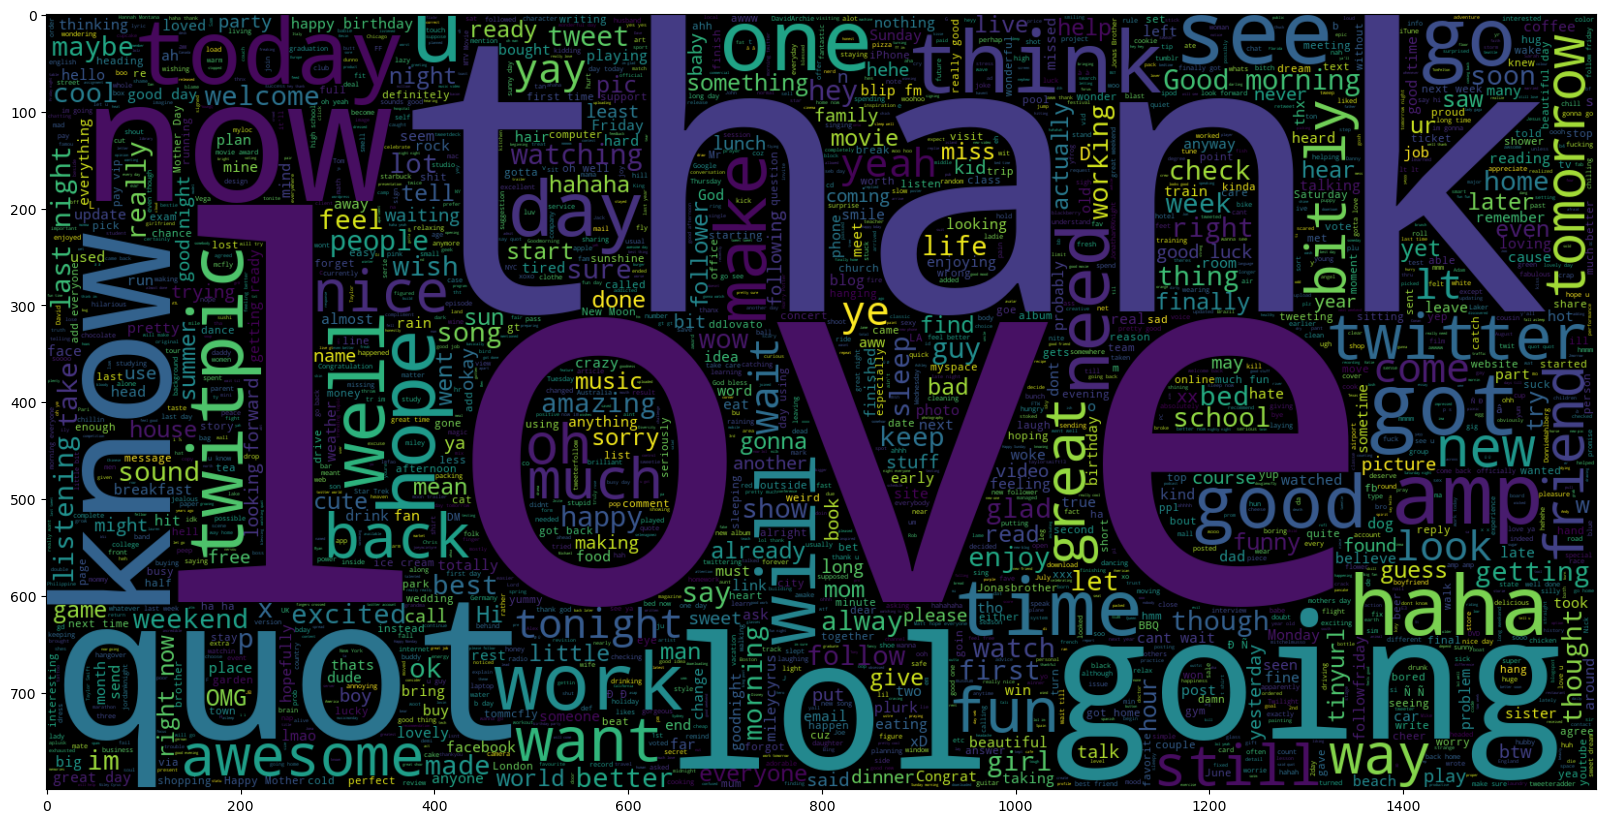

In [28]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 'positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

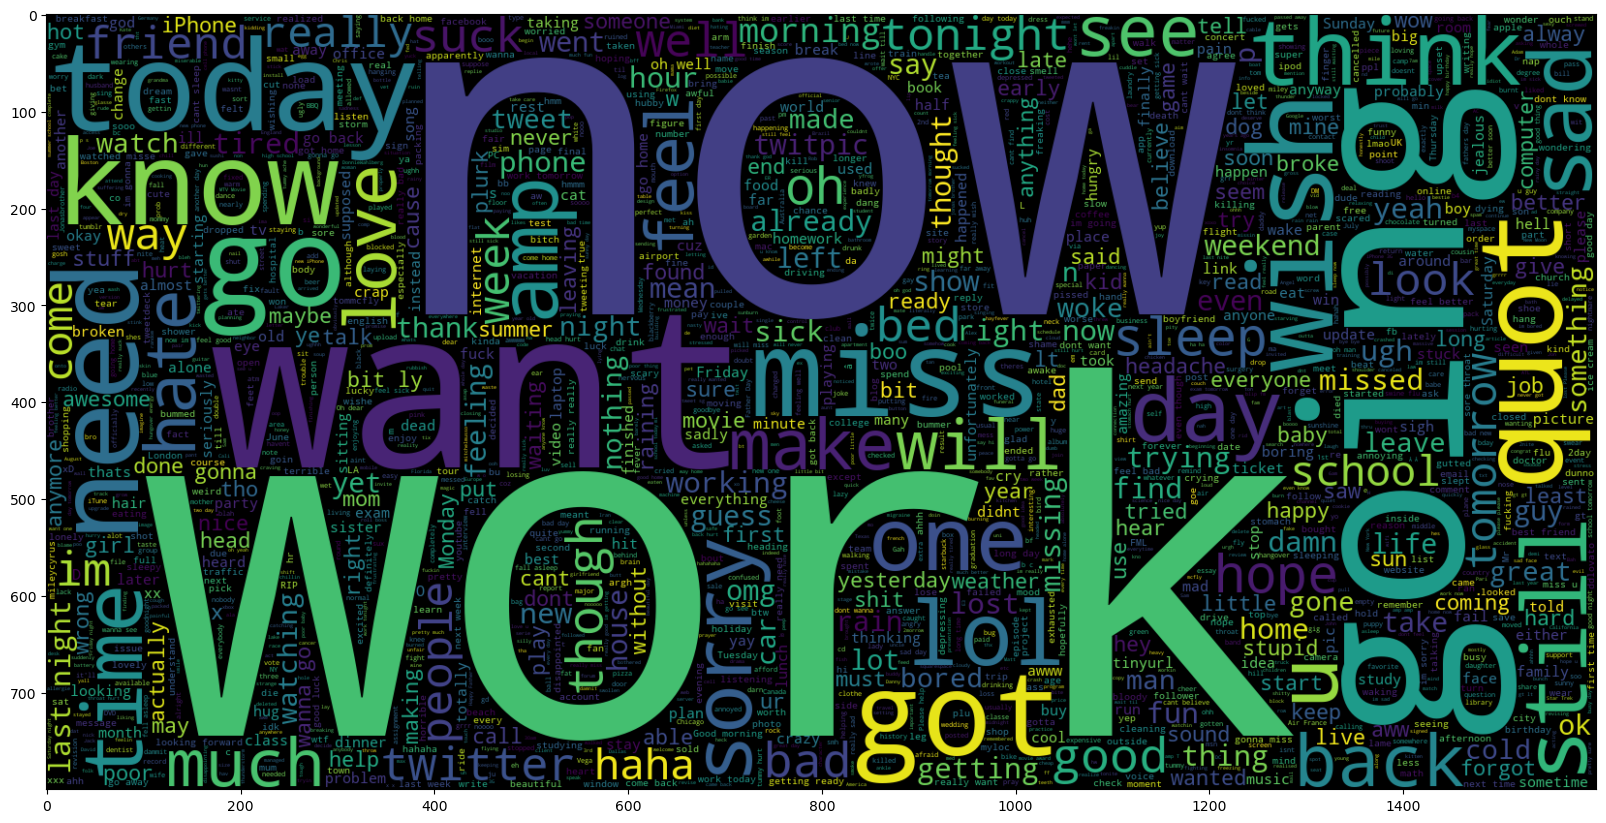

In [29]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 'negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

## Clean EDA

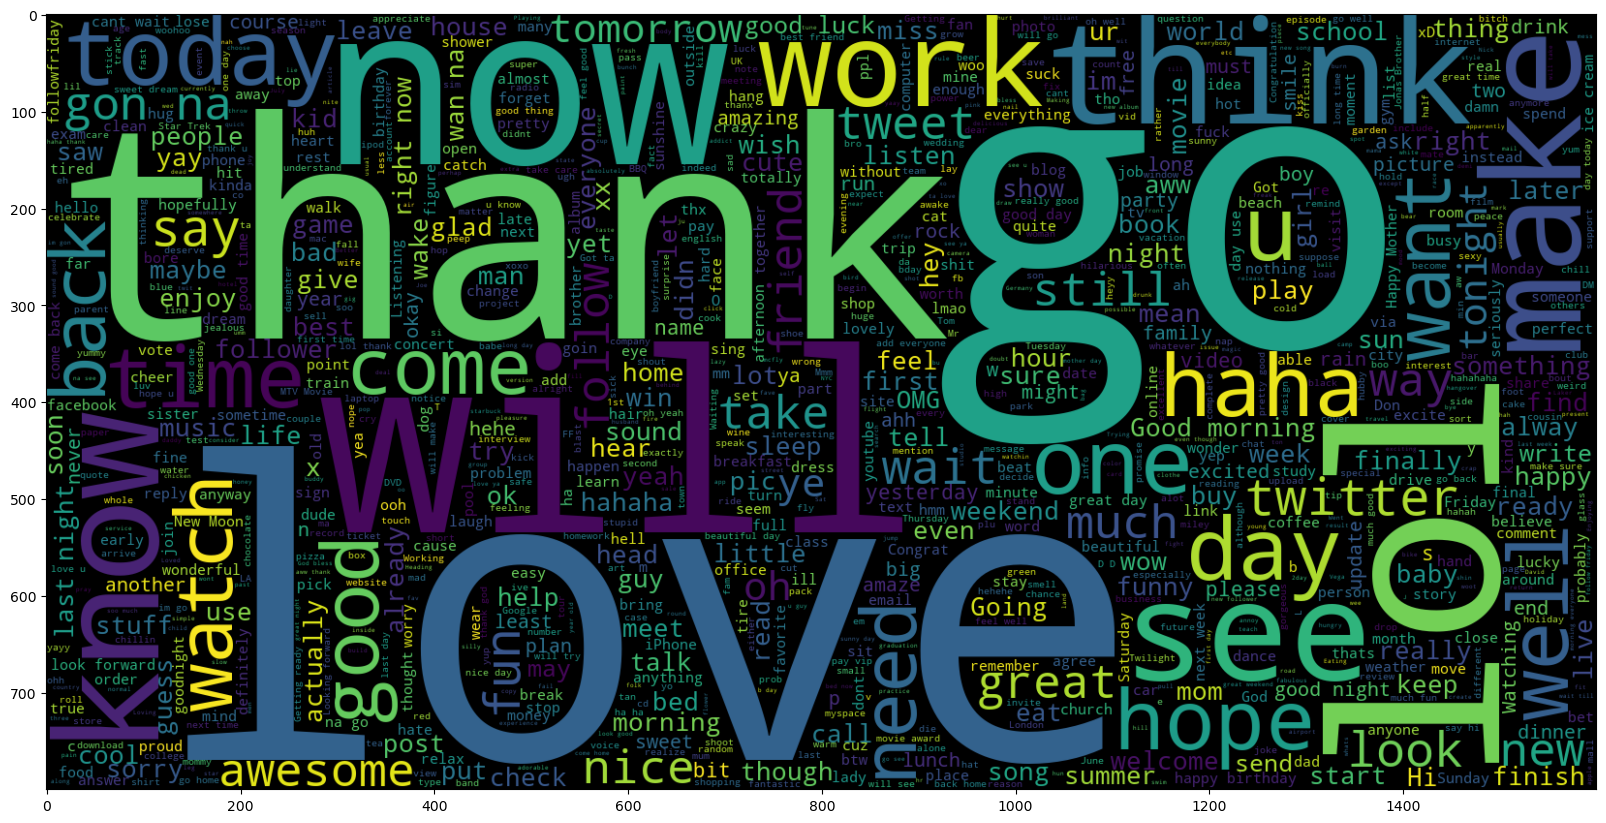

In [30]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(clean_data[clean_data.sentiment == 'positive'].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

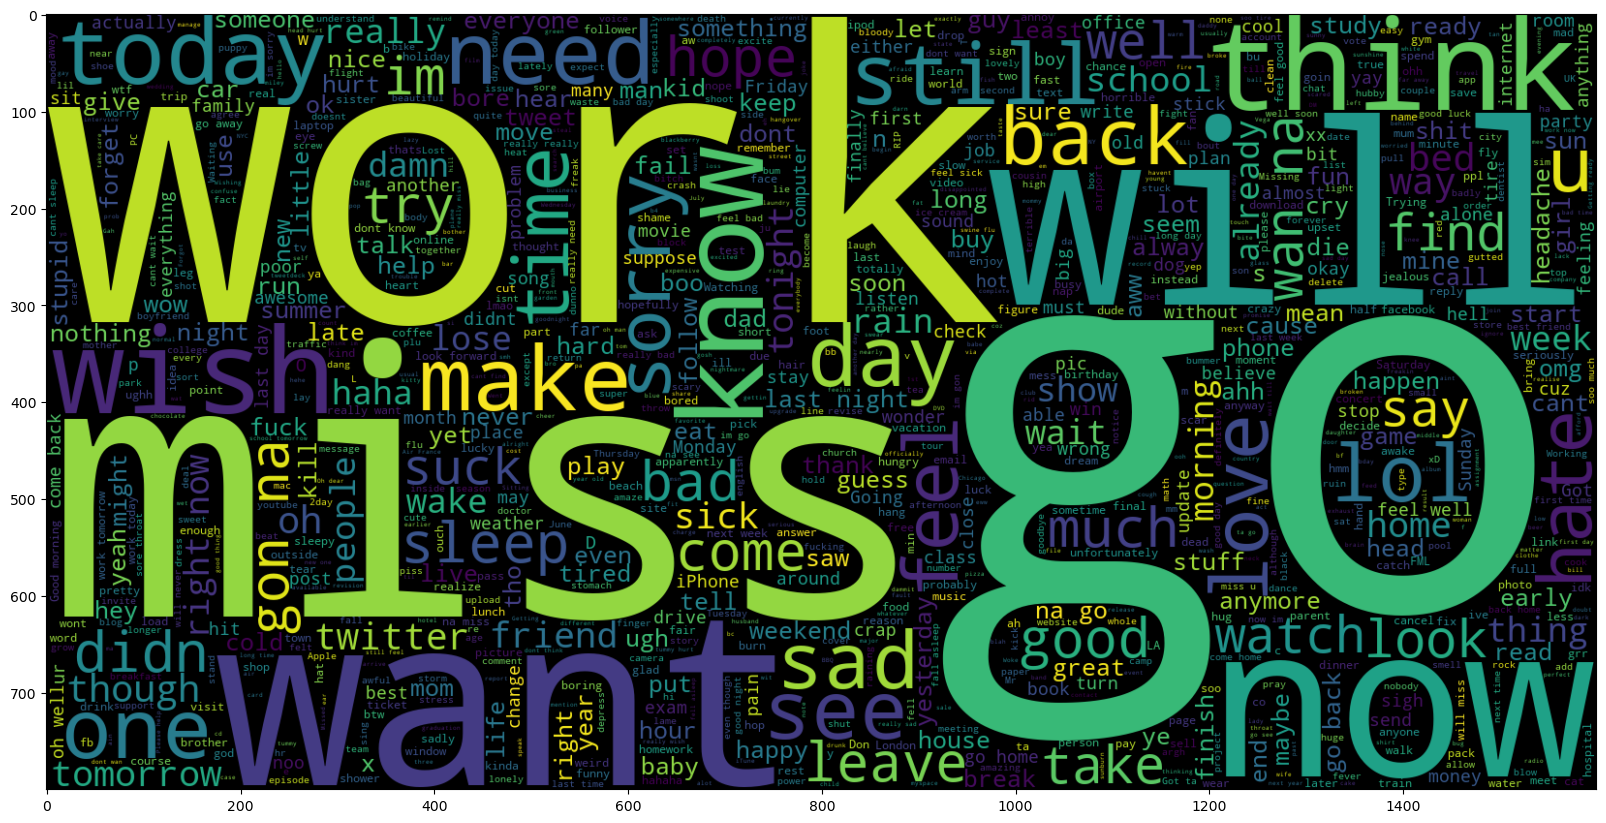

In [31]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(clean_data[clean_data.sentiment == 'negative'].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')